
##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [ ]:
# Copyright 2020 Google LLC. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Train a DDSP Autoencoder on GPU

This notebook demonstrates how to install the DDSP library and train it for synthesis based on your own data using our command-line scripts. If run inside of Colab, it will automatically use a free Google Cloud GPU.

At the end, you'll have a custom-trained checkpoint that you can download to use with the [DDSP Timbre Transfer Colab](https://colab.research.google.com/github/magenta/ddsp/blob/master/ddsp/colab/demos/timbre_transfer.ipynb).

<img src="https://storage.googleapis.com/ddsp/additive_diagram/ddsp_autoencoder.png" alt="DDSP Autoencoder figure" width="700">


**Note that we prefix bash commands with a `!` inside of Colab, but you would leave them out if running directly in a terminal.**

#### Set your base directory
* In drive, put all of the audio (.wav, .mp3) files with which you would like to train in a single folder.
 * Typically works well with 10-20 minutes of audio from a single monophonic source (also, one acoustic environment). 
* Use the file browser in the left panel to find a folder with your audio, right-click **"Copy Path", paste below**, and run the cell.

In [1]:
!pip install -qU ddsp[data_preparation]==1.0.1
!pip install -qU apache-beam==2.22.0

In [1]:
import os

DRIVE_DIR = '/home/ubuntu/DagstuhlChoirSet/audio_wav_22050_mono/trial' 
SAVE_DIR = os.path.join(DRIVE_DIR, 'ddsp-solo-instrument')
AUDIO_DIR = 'data/audio'
AUDIO_FILEPATTERN = AUDIO_DIR + '/*'
TRAIN_TFRECORD = 'data/train.tfrecord'
TRAIN_TFRECORD_FILEPATTERN = TRAIN_TFRECORD + '*'

#### Copy training audio

Copy audio files to use for training your model.

In [4]:
import glob
import os

mp3_files = glob.glob(os.path.join(DRIVE_DIR, '*.mp3'))
wav_files = glob.glob(os.path.join(DRIVE_DIR, '*.wav'))
audio_files = mp3_files + wav_files

for fname in audio_files:
    target_name = os.path.join(AUDIO_DIR, 
                             os.path.basename(fname).replace(' ', '_'))
    print('Copying {} to {}'.format(fname, target_name))
    !cp "$fname" $target_name

Copying /home/ubuntu/DagstuhlChoirSet/audio_wav_22050_mono/trial/DCS_LI_Basses_Take01_B1_DYN.wav to data/audio/DCS_LI_Basses_Take01_B1_DYN.wav


### Preprocess raw audio into TFRecord dataset

We need to do some preprocessing on the raw audio you uploaded to get it into the correct format for training. This involves turning the full audio into short (4-second) examples, inferring the fundamental frequency (or "pitch") with [CREPE](http://github.com/marl/crepe), and computing the loudness. These features will then be stored in a sharded [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord) file for easier loading. Depending on the amount of input audio, this process usually takes a few minutes.

* (Optional) Transfer dataset from drive. If you've already created a dataset, from a previous run, this cell will skip the dataset creation step and copy the dataset from `$DRIVE_DIR/data` 

In [5]:
!ddsp_prepare_tfrecord \
    --input_audio_filepatterns=$AUDIO_FILEPATTERN \
    --output_tfrecord_path=$TRAIN_TFRECORD \
    --num_shards=10 \
    --alsologtostderr

I0421 17:53:08.194244 140235006179136 translations.py:574] ==================== <function annotate_downstream_side_inputs at 0x7f8a4dace680> ====================
I0421 17:53:08.194832 140235006179136 translations.py:574] ==================== <function fix_side_input_pcoll_coders at 0x7f8a4dace7a0> ====================
I0421 17:53:08.195171 140235006179136 translations.py:574] ==================== <function lift_combiners at 0x7f8a4dace830> ====================
I0421 17:53:08.195319 140235006179136 translations.py:574] ==================== <function expand_sdf at 0x7f8a4dace8c0> ====================
I0421 17:53:08.195539 140235006179136 translations.py:574] ==================== <function expand_gbk at 0x7f8a4dace950> ====================
I0421 17:53:08.195917 140235006179136 translations.py:574] ==================== <function sink_flattens at 0x7f8a4dacea70> ====================
I0421 17:53:08.196082 140235006179136 translations.py:574] ==================== <function greedily_fuse at 0x

### Save dataset statistics for timbre transfer

Quantile normalization helps match loudness of timbre transfer inputs to the 
loudness of the dataset, so let's calculate it here and save in a pickle file.

In [2]:
import base64
import io
import pickle

import ddsp
import ddsp.training
from IPython import display
import note_seq
import numpy as np
from scipy import stats
from scipy.io import wavfile
import tensorflow.compat.v2 as tf
def save_dataset_statistics(data_provider, file_path, batch_size=1):
  """Calculate dataset stats and save in a pickle file."""
  print('Calculating dataset statistics for', data_provider)
  data_iter = iter(data_provider.get_batch(batch_size, repeats=1))

  # Unpack dataset.
  i = 0
  loudness = []
  f0 = []
  f0_conf = []
  audio = []

  for batch in data_iter:
    loudness.append(batch['loudness_db'])
    f0.append(batch['f0_hz'])
    f0_conf.append(batch['f0_confidence'])
    audio.append(batch['audio'])
    i += 1

  print(f'Computing statistics for {i * batch_size} examples.')

  loudness = np.vstack(loudness)
  f0 = np.vstack(f0)
  f0_conf = np.vstack(f0_conf)
  audio = np.vstack(audio)

  # Fit the transform.
  trim_end = 20
  f0_trimmed = f0[:, :-trim_end]
  l_trimmed = loudness[:, :-trim_end]
  f0_conf_trimmed = f0_conf[:, :-trim_end]
  mask_on, _ = detect_notes(l_trimmed, f0_conf_trimmed)
  quantile_transform = fit_quantile_transform(l_trimmed, mask_on)

  # Average values.
  mean_pitch = np.mean(ddsp.core.hz_to_midi(f0_trimmed[mask_on]))
  mean_loudness = np.mean(l_trimmed)
  mean_max_loudness = np.mean(np.max(l_trimmed, axis=0))

  # Object to pickle all the statistics together.
  ds = {'mean_pitch': mean_pitch,
        'mean_loudness': mean_loudness,
        'mean_max_loudness': mean_max_loudness,
        'quantile_transform': quantile_transform}

  # Save.
  with tf.io.gfile.GFile(file_path, 'wb') as f:
    pickle.dump(ds, f)
  print(f'Done! Saved to: {file_path}')

def detect_notes(loudness_db,
                 f0_confidence,
                 note_threshold=1.0,
                 exponent=2.0,
                 smoothing=40,
                 f0_confidence_threshold=0.7,
                 min_db=-120.):
  """Detect note on-off using loudness and smoothed f0_confidence."""
  mean_db = np.mean(loudness_db)
  db = smooth(f0_confidence**exponent, smoothing) * (loudness_db - min_db)
  db_threshold = (mean_db - min_db) * f0_confidence_threshold**exponent
  note_on_ratio = db / db_threshold
  mask_on = note_on_ratio >= note_threshold
  return mask_on, note_on_ratio

def smooth(x, filter_size=3):
  """Smooth 1-d signal with a box filter."""
  x = tf.convert_to_tensor(x, tf.float32)
  is_2d = len(x.shape) == 2
  x = x[:, :, tf.newaxis] if is_2d else x[tf.newaxis, :, tf.newaxis]
  w = tf.ones([filter_size])[:, tf.newaxis, tf.newaxis] / float(filter_size)
  y = tf.nn.conv1d(x, w, stride=1, padding='SAME')
  y = y[:, :, 0] if is_2d else y[0, :, 0]
  return y.numpy()

def fit_quantile_transform(loudness_db, mask_on, inv_quantile=None):
  """Fits quantile normalization, given a note_on mask.
  Optionally, performs the inverse transformation given a pre-fitted transform.
  Args:
    loudness_db: Decibels, shape [batch, time]
    mask_on: A binary mask for when a note is present, shape [batch, time].
    inv_quantile: Optional pretrained QuantileTransformer to perform the inverse
      transformation.
  Returns:
    Trained quantile transform. Also returns the renormalized loudnesses if
      inv_quantile is provided.
  """
  quantile_transform = QuantileTransformer()
  loudness_flat = np.ravel(loudness_db[mask_on])[:, np.newaxis]
  loudness_flat_q = quantile_transform.fit_transform(loudness_flat)

  if inv_quantile is None:
    return quantile_transform
  else:
    loudness_flat_norm = inv_quantile.inverse_transform(loudness_flat_q)
    loudness_norm = np.ravel(loudness_db.copy())[:, np.newaxis]
    loudness_norm[mask_on] = loudness_flat_norm
    return quantile_transform, loudness_norm

class QuantileTransformer:
  """Transform features using quantiles information.
  Stripped down version of sklearn.preprocessing.QuantileTransformer.
  https://github.com/scikit-learn/scikit-learn/blob/
  863e58fcd5ce960b4af60362b44d4f33f08c0f97/sklearn/preprocessing/_data.py
  Putting directly in ddsp library to avoid dependency on sklearn that breaks
  when pickling and unpickling from different versions of sklearn.
  """

  def __init__(self,
               n_quantiles=1000,
               output_distribution='uniform',
               subsample=int(1e5)):
    """Constructor.
    Args:
      n_quantiles: int, default=1000 or n_samples Number of quantiles to be
        computed. It corresponds to the number of landmarks used to discretize
        the cumulative distribution function. If n_quantiles is larger than the
        number of samples, n_quantiles is set to the number of samples as a
        larger number of quantiles does not give a better approximation of the
        cumulative distribution function estimator.
      output_distribution: {'uniform', 'normal'}, default='uniform' Marginal
        distribution for the transformed data. The choices are 'uniform'
        (default) or 'normal'.
      subsample: int, default=1e5 Maximum number of samples used to estimate
        the quantiles for computational efficiency. Note that the subsampling
        procedure may differ for value-identical sparse and dense matrices.
    """
    self.n_quantiles = n_quantiles
    self.output_distribution = output_distribution
    self.subsample = subsample
    self.random_state = np.random.mtrand._rand

  def _dense_fit(self, x, random_state):
    """Compute percentiles for dense matrices.
    Args:
      x: ndarray of shape (n_samples, n_features)
        The data used to scale along the features axis.
      random_state: Numpy random number generator.
    """
    n_samples, _ = x.shape
    references = self.references_ * 100

    self.quantiles_ = []
    for col in x.T:
      if self.subsample < n_samples:
        subsample_idx = random_state.choice(
            n_samples, size=self.subsample, replace=False)
        col = col.take(subsample_idx, mode='clip')
      self.quantiles_.append(np.nanpercentile(col, references))
    self.quantiles_ = np.transpose(self.quantiles_)
    # Due to floating-point precision error in `np.nanpercentile`,
    # make sure that quantiles are monotonically increasing.
    # Upstream issue in numpy:
    # https://github.com/numpy/numpy/issues/14685
    self.quantiles_ = np.maximum.accumulate(self.quantiles_)

  def fit(self, x):
    """Compute the quantiles used for transforming.
    Parameters
    ----------
    Args:
      x: {array-like, sparse matrix} of shape (n_samples, n_features)
        The data used to scale along the features axis. If a sparse
        matrix is provided, it will be converted into a sparse
        ``csc_matrix``. Additionally, the sparse matrix needs to be
        nonnegative if `ignore_implicit_zeros` is False.
    Returns:
      self: object
         Fitted transformer.
    """
    if self.n_quantiles <= 0:
      raise ValueError("Invalid value for 'n_quantiles': %d. "
                       'The number of quantiles must be at least one.' %
                       self.n_quantiles)
    n_samples = x.shape[0]
    self.n_quantiles_ = max(1, min(self.n_quantiles, n_samples))

    # Create the quantiles of reference
    self.references_ = np.linspace(0, 1, self.n_quantiles_, endpoint=True)
    self._dense_fit(x, self.random_state)
    return self

  def _transform_col(self, x_col, quantiles, inverse):
    """Private function to transform a single feature."""
    output_distribution = self.output_distribution
    bounds_threshold = 1e-7

    if not inverse:
      lower_bound_x = quantiles[0]
      upper_bound_x = quantiles[-1]
      lower_bound_y = 0
      upper_bound_y = 1
    else:
      lower_bound_x = 0
      upper_bound_x = 1
      lower_bound_y = quantiles[0]
      upper_bound_y = quantiles[-1]
      # for inverse transform, match a uniform distribution
      with np.errstate(invalid='ignore'):  # hide NaN comparison warnings
        if output_distribution == 'normal':
          x_col = stats.norm.cdf(x_col)
        # else output distribution is already a uniform distribution

    # find index for lower and higher bounds
    with np.errstate(invalid='ignore'):  # hide NaN comparison warnings
      if output_distribution == 'normal':
        lower_bounds_idx = (x_col - bounds_threshold < lower_bound_x)
        upper_bounds_idx = (x_col + bounds_threshold > upper_bound_x)
      if output_distribution == 'uniform':
        lower_bounds_idx = (x_col == lower_bound_x)
        upper_bounds_idx = (x_col == upper_bound_x)

    isfinite_mask = ~np.isnan(x_col)
    x_col_finite = x_col[isfinite_mask]
    if not inverse:
      # Interpolate in one direction and in the other and take the
      # mean. This is in case of repeated values in the features
      # and hence repeated quantiles
      #
      # If we don't do this, only one extreme of the duplicated is
      # used (the upper when we do ascending, and the
      # lower for descending). We take the mean of these two
      x_col[isfinite_mask] = .5 * (
          np.interp(x_col_finite, quantiles, self.references_) -
          np.interp(-x_col_finite, -quantiles[::-1], -self.references_[::-1]))
    else:
      x_col[isfinite_mask] = np.interp(x_col_finite, self.references_,
                                       quantiles)

    x_col[upper_bounds_idx] = upper_bound_y
    x_col[lower_bounds_idx] = lower_bound_y
    # for forward transform, match the output distribution
    if not inverse:
      with np.errstate(invalid='ignore'):  # hide NaN comparison warnings
        if output_distribution == 'normal':
          x_col = stats.norm.ppf(x_col)
          # find the value to clip the data to avoid mapping to
          # infinity. Clip such that the inverse transform will be
          # consistent
          clip_min = stats.norm.ppf(bounds_threshold - np.spacing(1))
          clip_max = stats.norm.ppf(1 - (bounds_threshold - np.spacing(1)))
          x_col = np.clip(x_col, clip_min, clip_max)
        # else output distribution is uniform and the ppf is the
        # identity function so we let x_col unchanged

    return x_col

  def _transform(self, x, inverse=False):
    """Forward and inverse transform.
    Args:
      x : ndarray of shape (n_samples, n_features)
        The data used to scale along the features axis.
      inverse : bool, default=False
        If False, apply forward transform. If True, apply
        inverse transform.
    Returns:
      x : ndarray of shape (n_samples, n_features)
        Projected data
    """
    x = np.array(x)  # Explicit copy.
    for feature_idx in range(x.shape[1]):
      x[:, feature_idx] = self._transform_col(
          x[:, feature_idx], self.quantiles_[:, feature_idx], inverse)
    return x

  def transform(self, x):
    """Feature-wise transformation of the data."""
    return self._transform(x, inverse=False)

  def inverse_transform(self, x):
    """Back-projection to the original space."""
    return self._transform(x, inverse=True)

  def fit_transform(self, x):
    """Fit and transform."""
    return self.fit(x).transform(x)


In [3]:
import ddsp.training

data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_dataset(shuffle=False)
PICKLE_FILE_PATH = os.path.join(SAVE_DIR, 'dataset_statistics.pkl')
save_dataset_statistics(data_provider, PICKLE_FILE_PATH, batch_size=1)

Calculating dataset statistics for <ddsp.training.data.TFRecordProvider object at 0x7f7e50977f10>
Computing statistics for 56 examples.
Done! Saved to: /home/ubuntu/DagstuhlChoirSet/audio_wav_22050_mono/trial/ddsp-solo-instrument/dataset_statistics.pkl


Let's load the dataset in the `ddsp` library and have a look at one of the examples.

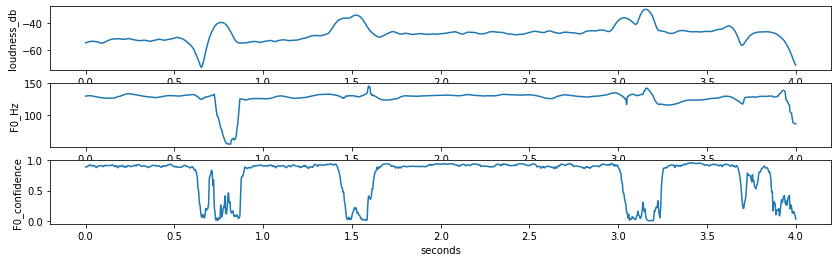

In [4]:
import ddsp.training
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import Audio

def play(audio):
    return Audio(audio, rate=16000)

data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_dataset(shuffle=False)

try:
  ex = next(iter(dataset))
except StopIteration:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')



f, ax = plt.subplots(3, 1, figsize=(14, 4))
x = np.linspace(0, 4.0, 1000)
ax[0].set_ylabel('loudness_db')
ax[0].plot(x, ex['loudness_db'])
ax[1].set_ylabel('F0_Hz')
ax[1].set_xlabel('seconds')
ax[1].plot(x, ex['f0_hz'])
ax[2].set_ylabel('F0_confidence')
ax[2].set_xlabel('seconds')
ax[2].plot(x, ex['f0_confidence'])
plt.show()
play(ex['audio'])

## Train Model

We will now train a "solo instrument" model. This means the model is conditioned only on the fundamental frequency (f0) and loudness with no instrument ID or latent timbre feature. If you uploaded audio of multiple instruemnts, the neural network you train will attempt to model all timbres, but will likely associate certain timbres with different f0 and loudness conditions. 

First, let's start up a [TensorBoard](https://www.tensorflow.org/tensorboard) to monitor our loss as training proceeds. 

Initially, TensorBoard will report `No dashboards are active for the current data set.`, but once training begins, the dashboards should appear.

In [5]:
%reload_ext tensorboard
import tensorboard as tb
tb.notebook.start('--logdir "{}"'.format(SAVE_DIR))

Reusing TensorBoard on port 6006 (pid 8995), started 12:25:44 ago. (Use '!kill 8995' to kill it.)

### We will now begin training. 

Note that we specify [gin configuration](https://github.com/google/gin-config) files for the both the model architecture ([solo_instrument.gin](TODO)) and the dataset ([tfrecord.gin](TODO)), which are both predefined in the library. You could also create your own. We then override some of the spefic params for `batch_size` (which is defined in in the model gin file) and the tfrecord path (which is defined in the dataset file). 

### Training Notes:
* Models typically perform well when the loss drops to the range of ~4.5-5.0.
* Depending on the dataset this can take anywhere from 5k-30k training steps usually.
* The default is set to 30k, but you can stop training at any time, and for timbre transfer, it's best to stop before the loss drops too far below ~5.0 to avoid overfitting.
* On the colab GPU, this can take from around 3-20 hours. 
* We **highly recommend** saving checkpoints directly to your drive account as colab will restart naturally after about 12 hours and you may lose all of your checkpoints.
* By default, checkpoints will be saved every 300 steps with a maximum of 10 checkpoints (at ~60MB/checkpoint this is ~600MB). Feel free to adjust these numbers depending on the frequency of saves you would like and space on your drive.
* If you're restarting a session and `DRIVE_DIR` points a directory that was previously used for training, training should resume at the last checkpoint.

In [12]:
!ddsp_run \
  --mode=train \
  --save_dir="$SAVE_DIR" \
  --gin_file=models/solo_instrument.gin \
  --gin_file=datasets/tfrecord.gin \
  --gin_param="TFRecordProvider.file_pattern='data/train.tfrecord*'" \
  --gin_param="batch_size=10" \
  --gin_param="train_util.train.num_steps=300" \
  --gin_param="train_util.train.steps_per_save=300" \
  --gin_param="trainers.Trainer.checkpoints_to_keep=10"\
  --alsologtostderr \
  --allow_memory_growth=False

I0421 18:58:47.895516 140700002649920 ddsp_run.py:176] Restore Dir: /home/ubuntu/DagstuhlChoirSet/audio_wav_22050_mono/trial/ddsp-solo-instrument
I0421 18:58:47.895803 140700002649920 ddsp_run.py:177] Save Dir: /home/ubuntu/DagstuhlChoirSet/audio_wav_22050_mono/trial/ddsp-solo-instrument
I0421 18:58:47.895952 140700002649920 resource_reader.py:50] system_path_file_exists:optimization/base.gin
E0421 18:58:47.896135 140700002649920 resource_reader.py:55] Path not found: optimization/base.gin
I0421 18:58:47.897304 140700002649920 resource_reader.py:50] system_path_file_exists:eval/basic.gin
E0421 18:58:47.897505 140700002649920 resource_reader.py:55] Path not found: eval/basic.gin
I0421 18:58:47.898576 140700002649920 resource_reader.py:50] system_path_file_exists:models/solo_instrument.gin
E0421 18:58:47.898758 140700002649920 resource_reader.py:55] Path not found: models/solo_instrument.gin
I0421 18:58:47.898971 140700002649920 resource_reader.py:50] system_path_file_exists:models/ae.gi

## Resynthesis

Check how well the model reconstructs the training data

In [ ]:
from ddsp.colab.colab_utils import play, specplot
import ddsp.training
import gin
from matplotlib import pyplot as plt
import numpy as np

data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_batch(batch_size=1, shuffle=False)

try:
  batch = next(iter(dataset))
except OutOfRangeError:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

# Parse the gin config.
gin_file = os.path.join(SAVE_DIR, 'operative_config-0.gin')
gin.parse_config_file(gin_file)

# Load model
model = ddsp.training.models.Autoencoder()
model.restore(SAVE_DIR)

# Resynthesize audio.
outputs = model(batch, training=False)
audio_gen = model.get_audio_from_outputs(outputs)
audio = batch['audio']

print('Original Audio')
specplot(audio)
play(audio)

print('Resynthesis')
specplot(audio_gen)
play(audio_gen)

## Download Checkpoint

Below you can download the final checkpoint. You are now ready to use it in the [DDSP Timbre Tranfer Colab](https://colab.research.google.com/github/magenta/ddsp/blob/master/ddsp/colab/demos/timbre_transfer.ipynb).

In [ ]:
from ddsp.colab import colab_utils
import tensorflow as tf
import os

CHECKPOINT_ZIP = 'my_solo_instrument.zip'
latest_checkpoint_fname = os.path.basename(tf.train.latest_checkpoint(SAVE_DIR))
!cd "$SAVE_DIR" && zip $CHECKPOINT_ZIP $latest_checkpoint_fname* operative_config-0.gin dataset_statistics.pkl
!cp "$SAVE_DIR/$CHECKPOINT_ZIP" ./
colab_utils.download(CHECKPOINT_ZIP)